In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images384x576.zip'

### Dependencies

In [4]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
#@title
from keras.optimizers import Optimizer

class AdamAccumulated(Optimizer):
    """Adam optimizer with gradient accumulation.
    Default parameters follow those provided in the original paper.
    # Arguments
        accumulation_steps: int > 0. Update gradient in every accumulation steps.
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, accumulation_steps, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, **kwargs):
        super(AdamAccumulated, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.accumulation_steps = K.variable(accumulation_steps, dtype='int64', name='accumulation_steps')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        update_cond = K.equal((self.iterations + 1) % self.accumulation_steps, 0)
        sub_step = self.iterations % self.accumulation_steps + 1
        t = K.cast(self.iterations // self.accumulation_steps, K.floatx()) + 1

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))
        lr_t = K.switch(update_cond, lr_t, 0.0)

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]
        self.weights = [self.iterations] + ms + vs + vhats

        acc_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        for grad, acc_grad in zip(grads, acc_grads):
            ave_grad = grad / K.cast(self.accumulation_steps, K.floatx())
            self.updates.append(K.update(
                acc_grad,
                K.switch(
                    K.equal(sub_step, 1),
                    ave_grad,
                    acc_grad + (ave_grad - acc_grad) / K.cast(sub_step, K.floatx())
                ),
            ))
        grads = [K.switch(update_cond, grad, K.zeros_like(grad)) for grad in acc_grads]

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = K.switch(update_cond, (self.beta_1 * m) + (1. - self.beta_1) * g, m)
            v_t = K.switch(update_cond, (self.beta_2 * v) + (1. - self.beta_2) * K.square(g), v)
            if self.amsgrad:
                vhat_t = K.switch(update_cond, K.maximum(vhat, v_t), vhat)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'accumulation_steps': int(K.get_value(self.accumulation_steps)),
                  'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulated, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
model_base_path = base_path + 'Models/files/segmentation/'
train_path = data_path + 'train.csv'
hold_out_set_path = data_path + 'hold-out.csv'
train_images_path = 'train_images/'

### Load data

In [8]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_set_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,1f3d231.jpg,NaN,1625401 196 1625598 4 1625607 1 1625612 5 1625...,NaN,NaN,0,1,0,0,train
1,0fa3287.jpg,NaN,121884 511 123284 511 124684 511 126084 511 12...,NaN,32739 369 34139 369 35539 369 36939 369 38339 ...,0,1,0,1,train
2,4d17338.jpg,64 1141 1464 1141 2864 1141 4264 1141 5664 114...,NaN,NaN,13141 707 14541 707 15941 707 17341 707 18741 ...,1,0,0,1,train
3,12e55a8.jpg,NaN,1187509 1060 1188909 1060 1190309 1060 1191709...,NaN,2808 614 4208 614 5608 614 7008 614 8408 614 9...,0,1,0,1,train
4,697eb53.jpg,52180 1006 53580 1006 54980 1006 56380 1006 57...,NaN,NaN,NaN,1,0,0,0,train


# Model parameters

In [0]:
BACKBONE = 'efficientnetb0'
BATCH_SIZE = 8
EPOCHS = 15
LEARNING_RATE = 3e-4
HEIGHT = 384
WIDTH = 576
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 4
RLROP_PATIENCE = 2
DECAY_DROP = 0.2
ACC_STEPS = 4
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

model_name = '72-unet_%s_%sx%s' % (BACKBONE, HEIGHT, WIDTH)
model_path = model_base_path + '%s.h5' % (model_name)
prev_model_path = model_base_path + '71-unet_efficientnetb0_320x480.h5'

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.OneOf([
                                  albu.HorizontalFlip(p=0.5),
                                  albu.VerticalFlip(p=0.5),
                                  albu.Flip(p=0.5),
                                  ], p=0.6),
                             albu.OneOf([
                                  albu.GridDistortion(p=0.5),
                                  albu.OpticalDistortion(p=0.2),
                                  albu.ElasticTransform(p=0.5),
                                  ], p=0.4),
                             albu.OneOf([
                                  albu.RandomContrast(p=0.5),
                                  albu.RandomBrightnessContrast(p=0.5),
                                  ], p=0.5),
                             albu.OneOf([
                                  albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, 
                                                        shift_limit=0.1, border_mode=0, p=0.5),
                                  ], p=0.3),
                            ])

### Data generator

In [0]:
train_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Model pt1

In [0]:
model = load_model(prev_model_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

# Model

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = AdamAccumulated(lr=LEARNING_RATE, accumulation_steps=ACC_STEPS)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
# model.summary()

In [21]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

Epoch 1/15
552/552 [==============================] - 800s 1s/step - loss: 0.8129 - dice_coef: 0.5120 - iou_score: 0.3422 - f1-score: 0.4976 - val_loss: 0.7692 - val_dice_coef: 0.5570 - val_iou_score: 0.3712 - val_f1-score: 0.5269
Epoch 2/15
552/552 [==============================] - 750s 1s/step - loss: 0.8019 - dice_coef: 0.5184 - iou_score: 0.3482 - f1-score: 0.5049 - val_loss: 0.7931 - val_dice_coef: 0.5275 - val_iou_score: 0.3465 - val_f1-score: 0.5007
Epoch 3/15
552/552 [==============================] - 738s 1s/step - loss: 0.7969 - dice_coef: 0.5227 - iou_score: 0.3517 - f1-score: 0.5076 - val_loss: 0.7775 - val_dice_coef: 0.5587 - val_iou_score: 0.3725 - val_f1-score: 0.5275

Epoch 00003: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
Epoch 4/15
552/552 [==============================] - 752s 1s/step - loss: 0.7762 - dice_coef: 0.5358 - iou_score: 0.3642 - f1-score: 0.5212 - val_loss: 0.7549 - val_dice_coef: 0.5598 - val_iou_score: 0.3743 - val_f1-score: 0.

## Model loss graph

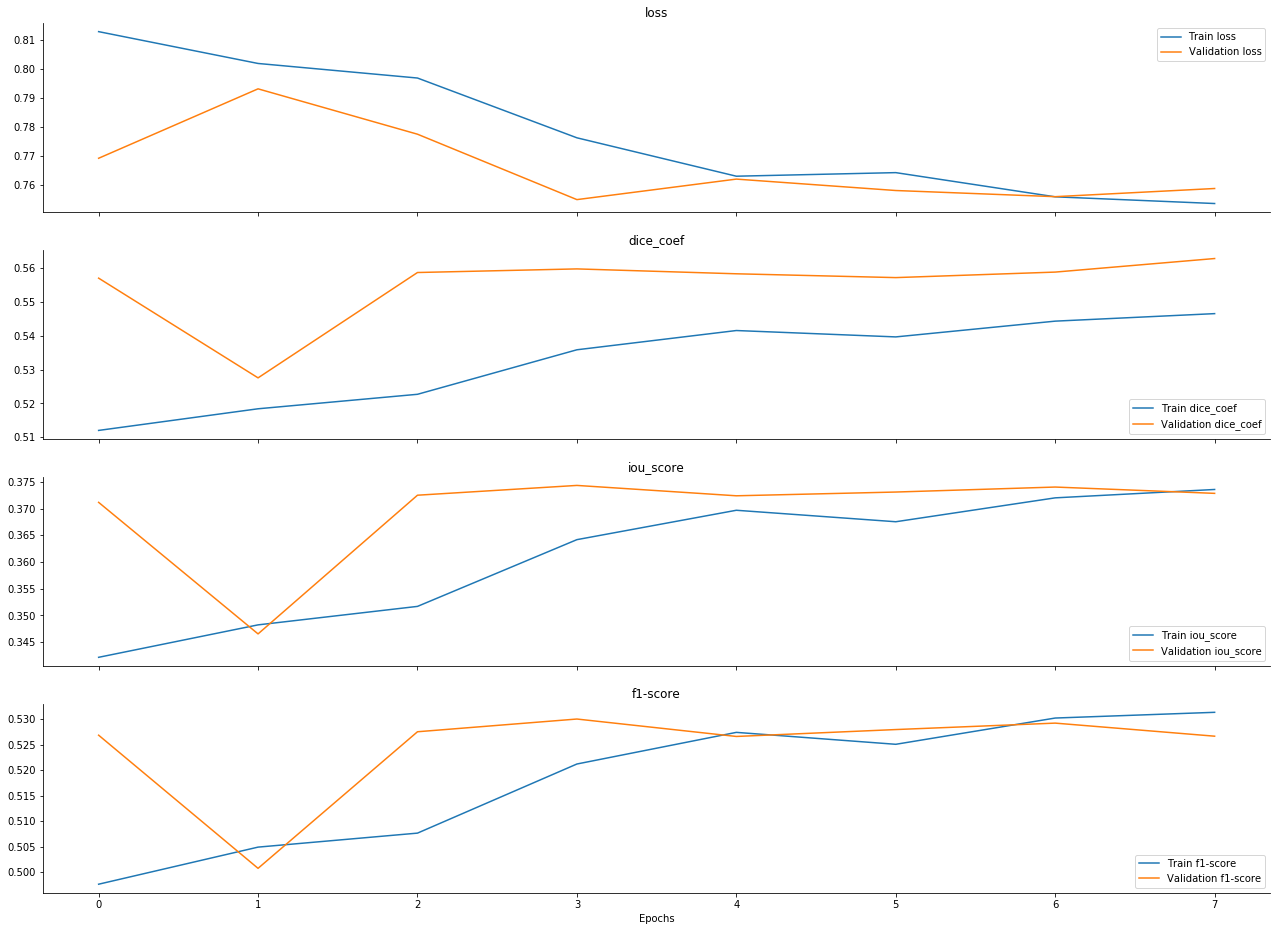

In [22]:
#@title
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'f1-score'])